## 루브릭

1. 모델과 데이터를 정상적으로 불러오고, 작동하는 것을 확인하였다.	
    - klue/bert-base를 NSMC 데이터셋으로 fine-tuning 하여, 모델이 정상적으로 작동하는 것을 확인하였다.

2. Preprocessing을 개선하고, fine-tuning을 통해 모델의 성능을 개선시켰다.	
    - Validation accuracy를 90% 이상으로 개선하였다.

3. 모델 학습에 Bucketing을 성공적으로 적용하고, 그 결과를 비교분석하였다.	
    - Bucketing task을 수행하여 fine-tuning 시 연산 속도와 모델 성능 간의 trade-off 관계가 발생하는지 여부를 확인하고, 분석한 결과를 제시하였다.


model(klue/ber-base)를 활용하여 NSMC(Naver Sentiment Movie Corpus) task

## 1. NSMC 데이터 분석 및 Huggingface dataset 구성

In [2]:
import datasets
from datasets import load_dataset

# NSMC 데이터셋 로드
nsmc_dataset = load_dataset('e9t/nsmc')


print(nsmc_dataset)

Using custom data configuration default
Reusing dataset nsmc (/aiffel/.cache/huggingface/datasets/e9t___nsmc)/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3)


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 150000
    })
    test: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 50000
    })
})


In [3]:
train = nsmc_dataset['train']
test = nsmc_dataset['test']
print("Column Name : ", train.column_names)
print("Train Count : ", len(train))
print("Test Count : ", len(test))

Column Name :  ['id', 'document', 'label']
Train Count :  150000
Test Count :  50000


In [4]:
print(train[0])

{'id': '9976970', 'document': '아 더빙.. 진짜 짜증나네요 목소리', 'label': 0}


## 2. klue/bert-base model 및 tokenizer 불러오기

In [5]:
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification

huggingface_tokenizer = AutoTokenizer.from_pretrained('klue/bert-base')
huggingface_model = AutoModelForSequenceClassification.from_pretrained('klue/bert-base', num_labels = 2)

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized

In [6]:
huggingface_tokenizer.model_max_length

512

In [7]:
from transformers import AutoConfig


config = AutoConfig.from_pretrained('klue/bert-base')
config

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.11.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 32000
}

## 3. tokenizer으로 데이터셋을 전처리하고, model 학습 진행해 보기

### 3.1 preprocess

**중복제거**

In [8]:
# pandas 구조체로 바꾸어서 중복제거하는 방법
train_df = nsmc_dataset['train'].to_pandas()
test_df = nsmc_dataset['test'].to_pandas()

In [9]:
null_examples = nsmc_dataset['train'].filter(lambda x: x['document'] is None or x['label'] is None)
null_examples[:5]

Loading cached processed dataset at /aiffel/.cache/huggingface/datasets/e9t___nsmc)/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3/cache-a36f85886b79e5a2.arrow


{'id': [], 'document': [], 'label': []}

In [10]:
# datasets의 filter를 이용하는 방법
from datasets import DatasetDict

train = nsmc_dataset['train']
test = nsmc_dataset['test']


# 1. Train 중복 제거
seen_trains = set()
def is_unique_train(example):
    doc = example['document']
    if doc in seen_trains:
        return False
    seen_trains.add(doc)
    return True

train_dedup = train.filter(is_unique_train)

# 2. Test 중복 제거 - seen_documents 새로 만듦
seen_tests = set()
def is_unique_test(example):
    doc = example['document']
    if doc in seen_tests:
        return False
    seen_tests.add(doc)
    return True

test_dedup = test.filter(is_unique_test)


# 3. 결과 출력
print("Unique Train Count : ", len(train_dedup))
print("Unique Test Count : ", len(test_dedup))


# 4. Null 및 빈 문장 제거
def is_valid(example):
    return (
        example['document'] is not None and 
        example['document'].strip() != '' and 
        example['label'] is not None
    )

train_dedup = train_dedup.filter(is_valid)
test_dedup = test_dedup.filter(is_valid)

print("Valid Train Count : ", len(train_dedup))
print("Valid Test Count : ", len(test_dedup))

# 5. 데이타 전처리
import re

def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z가-힣]+", " ", sentence)
    sentence = sentence.strip()

    return sentence

def preprocess_example(example):
    example["document"] = preprocess_sentence(example["document"])
    return example

train_dedup = train_dedup.map(preprocess_example)
test_dedup = test_dedup.map(preprocess_example)

#print("Column Name : ", train.column_names)

# 6. 새 DatasetDict 생성
deduped_dataset = DatasetDict({
    'train': train_dedup,
    'test': test_dedup
})

print(deduped_dataset)

Loading cached processed dataset at /aiffel/.cache/huggingface/datasets/e9t___nsmc)/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3/cache-7aad60309157b49e.arrow
Loading cached processed dataset at /aiffel/.cache/huggingface/datasets/e9t___nsmc)/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3/cache-4bf60c9b0c073c16.arrow
Loading cached processed dataset at /aiffel/.cache/huggingface/datasets/e9t___nsmc)/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3/cache-af441d2fbe25709d.arrow
Loading cached processed dataset at /aiffel/.cache/huggingface/datasets/e9t___nsmc)/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3/cache-e2e4203d2923fa80.arrow
Loading cached processed dataset at /aiffel/.cache/huggingface/datasets/e9t___nsmc)/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3/cache-0ae15e14e834fd78.arrow
Loading cached processed dataset at /aif

Unique Train Count :  146183
Unique Test Count :  49158
Valid Train Count :  146182
Valid Test Count :  49157
DatasetDict({
    train: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 146182
    })
    test: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 49157
    })
})


### 3.2 토크나이저 적용

In [10]:
def transform(data):
    return huggingface_tokenizer(
        data['document'],
        truncation = True,
        padding = 'max_length',
        return_token_type_ids = False,
        )

# map을 사용해 토크나이징을 진행하기 때문에 batch를 적용해야 되므로 batched=True로 주어야 한다.
#hf_dataset = nsmc_dataset.map(transform, batched=True)
hf_dataset = deduped_dataset.map(transform, batched=True)

# train & test split
hf_train_dataset = hf_dataset['train']
hf_test_dataset = hf_dataset['test']

  0%|          | 0/147 [00:00<?, ?ba/s]

Loading cached processed dataset at /aiffel/.cache/huggingface/datasets/e9t___nsmc)/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3/cache-e23086abae639ae4.arrow


In [11]:
cols = hf_train_dataset.column_names
cols

['attention_mask', 'document', 'id', 'input_ids', 'label']

In [12]:
mis_cnt = 0
for i in range(len(hf_test_dataset)): 
    if mis_cnt > 10 : 
        break
    label = hf_test_dataset[i]['label']
    if label < 0 or label > 1 : 
        print(f'{i} : {label}' )
        mis_cnt +=1

print(mis_cnt)

0


In [13]:
t= hf_test_dataset[0]
print("document ;", t['document'])
print("input_ids ;", t['input_ids'])
print("label ;", t['label'])

print(len(t['attention_mask']))
    
    

document ; 굳
input_ids ; [2, 618, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

- seq_len는 512로 패딩이 많이 들어간다

**적당한 seq_len를 찾아서 패딩되는 크기를 줄이자**

**문자길이 분포 구하기**

Loading cached processed dataset at /aiffel/.cache/huggingface/datasets/e9t___nsmc)/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3/cache-20968f37d6f2fbfd.arrow
Loading cached processed dataset at /aiffel/.cache/huggingface/datasets/e9t___nsmc)/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3/cache-9d3338872bcd74d3.arrow


최소 길이: 0
최대 길이: 140
평균 길이: 32.92670780260224


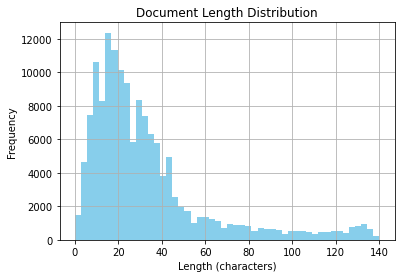

최소 길이: 0
최대 길이: 140
평균 길이: 32.819028826006466


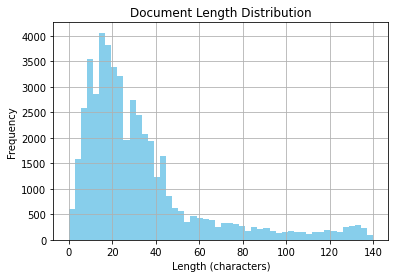

In [14]:
train = deduped_dataset['train']
test = deduped_dataset['test']

# 1. 각 문장의 길이를 계산해서 새로운 column에 추가
def add_length(example):
    example["length"] = len(example["document"])
    return example

train_with_length = train.map(add_length)
test_with_length = test.map(add_length)

# 2. train 길이 분포 통계 
lengths = train_with_length["length"]

# 기초 통계
print("최소 길이:", min(lengths))
print("최대 길이:", max(lengths))
print("평균 길이:", sum(lengths) / len(lengths))

import matplotlib.pyplot as plt

plt.hist(lengths, bins=50, color='skyblue')
plt.title("Document Length Distribution")
plt.xlabel("Length (characters)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# 3. test 길이 분포 통계 
test_lengths = test_with_length["length"]

# 기초 통계
print("최소 길이:", min(test_lengths))
print("최대 길이:", max(test_lengths))
print("평균 길이:", sum(test_lengths) / len(test_lengths))

import matplotlib.pyplot as plt

plt.hist(test_lengths, bins=50, color='skyblue')
plt.title("Document Length Distribution")
plt.xlabel("Length (characters)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

**토큰 길이 분포**

loading configuration file https://huggingface.co/klue/bert-base/resolve/main/config.json from cache at /aiffel/.cache/huggingface/transformers/fbd0b2ef898c4653902683fea8cc0dd99bf43f0e082645b913cda3b92429d1bb.99b3298ed554f2ad731c27cdb11a6215f39b90bc845ff5ce709bb4e74ba45621
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.11.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 32000
}

loading file https://huggingface.co/klue/bert-base/resolve/main/vocab.txt from cache at /aiffel/.cache/huggingface/transformers/1a36e69d48a0

최소 길이: 0
최대 길이: 117
평균 길이: 17.810790658220576


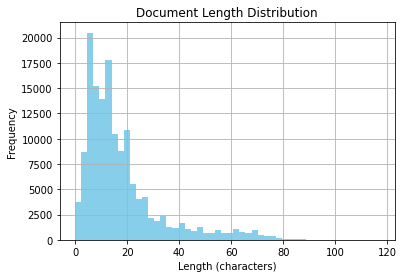

최소 길이: 0
최대 길이: 117
평균 길이: 17.783082775596558


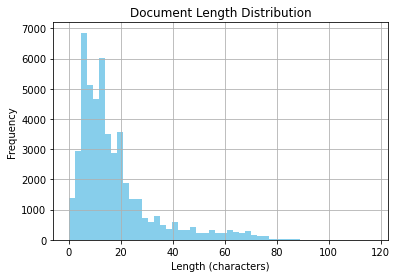

In [24]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")

train = deduped_dataset['train']
test = deduped_dataset['test']

# 1. 각 토큰의 길이를 계산해서 새로운 column에 추가
def add_token_length(example):
    tokens = tokenizer.tokenize(example["document"])
    example["token_length"] = len(tokens)
    return example

train_with_tokens  = train.map(add_token_length)
test_with_tokens = test.map(add_token_length)

# 2. train 토큰 길이 분포 통계 
lengths = train_with_tokens["token_length"]

# 기초 통계
print("최소 길이:", min(lengths))
print("최대 길이:", max(lengths))
print("평균 길이:", sum(lengths) / len(lengths))

import matplotlib.pyplot as plt

plt.hist(lengths, bins=50, color='skyblue')
plt.title("Document Length Distribution")
plt.xlabel("Length (characters)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# 3. test 길이 분포 통계 
test_lengths = test_with_tokens["token_length"]

# 기초 통계
print("최소 길이:", min(test_lengths))
print("최대 길이:", max(test_lengths))
print("평균 길이:", sum(test_lengths) / len(test_lengths))

import matplotlib.pyplot as plt

plt.hist(test_lengths, bins=50, color='skyblue')
plt.title("Document Length Distribution")
plt.xlabel("Length (characters)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

최대 길이: 117
평균 길이: 17.78272102201066

In [25]:
train_with_tokens

Dataset({
    features: ['id', 'document', 'label', 'token_length'],
    num_rows: 146182
})

In [27]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if( s <= max_len):
            cnt = cnt + 1

    ratio = cnt / len(nested_list)
    print("전체 샘플 중 토큰 길이가 {} 이하인 샘플의 비율: {:.3f} (총 {}개)".format(max_len, ratio, int(len(nested_list) * ratio)))


below_threshold_len( 64, train_with_tokens['token_length'])

below_threshold_len( 40, train_with_tokens['token_length'])


전체 샘플 중 토큰 길이가 64 이하인 샘플의 비율: 0.975 (총 142522개)
전체 샘플 중 토큰 길이가 40 이하인 샘플의 비율: 0.910 (총 133079개)


### 3.3 토크나이저 변경하여 적용 (max_length=64)

In [16]:
def transform(data):
    return huggingface_tokenizer(
        data['document'],
        truncation = True,
        padding = 'max_length',
        max_length=64, 
        return_token_type_ids = False, 
        )

# map을 사용해 토크나이징을 진행하기 때문에 batch를 적용해야 되므로 batched=True로 주어야 한다.
hf_dataset = deduped_dataset.map(transform, batched=True)

# train & test split
hf_train_dataset = hf_dataset['train']
hf_test_dataset = hf_dataset['test']

Loading cached processed dataset at /aiffel/.cache/huggingface/datasets/e9t___nsmc)/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3/cache-94ad7cb716bbae8f.arrow


  0%|          | 0/50 [00:00<?, ?ba/s]

In [17]:
hf_dataset

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'document', 'id', 'input_ids', 'label'],
        num_rows: 146182
    })
    test: Dataset({
        features: ['attention_mask', 'document', 'id', 'input_ids', 'label'],
        num_rows: 49157
    })
})

In [18]:
t= hf_test_dataset[0]
print("document ;", t['document'])
print("input_ids ;", t['input_ids'])
print("label ;", t['label'])

print(len(t['attention_mask']))
    

document ; 굳
input_ids ; [2, 618, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
label ; 1
64


### 3.4 model 학습 진행

**Metrics**

In [11]:
# NSMC 데이터셋은 binary classification
from datasets import load_metric

# 정확도와 F1-score metric 불러오기
accuracy_metric = load_metric("accuracy")
f1_metric = load_metric("f1")

def compute_metrics(eval_pred):    
    predictions,labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"]
    f1 = f1_metric.compute(predictions=predictions, references=labels)["f1"]
    return {"accuracy": accuracy, "f1": f1}


**기본 성능**

In [11]:
import os
# 디버깅용이며, 속도가 느려지므로, 실제 모델학습에서는 꺼두어야 한다. 
#os.environ["CUDA_LAUNCH_BLOCKING"] = "1"  

In [45]:
# 1. train 데이터를 90:10 비율로 나누기
split_ds = hf_train_dataset.train_test_split(test_size=0.1, seed=42)
hf_train_dataset = split_ds['train']
hf_val_dataset = split_ds['test']

print(hf_train_dataset)
print(hf_val_dataset)

Dataset({
    features: ['attention_mask', 'document', 'id', 'input_ids', 'label'],
    num_rows: 131563
})
Dataset({
    features: ['attention_mask', 'document', 'id', 'input_ids', 'label'],
    num_rows: 14619
})


In [46]:
import os
import numpy as np
from transformers import Trainer, TrainingArguments

output_dir = os.getenv('HOME')+'/aiffel/transformers'

training_arguments = TrainingArguments(
    output_dir,                                         # output이 저장될 경로
    evaluation_strategy="epoch",           #evaluation하는 빈도
    logging_strategy="epoch",           # epoch마다 로그 기록
    learning_rate = 2e-5,                         #learning_rate
    per_device_train_batch_size = 32,   # 각 device 당 batch size
    per_device_eval_batch_size = 32,    # evaluation 시에 batch size
    num_train_epochs = 3,                     # train 시킬 총 epochs
    weight_decay = 0.01,                        # weight decay
    logging_dir="./case3_logs",
    fp16  = True
)


trainer = Trainer(
    model=huggingface_model,           # 학습시킬 model
    args=training_arguments,           # TrainingArguments을 통해 설정한 arguments
    train_dataset=hf_train_dataset,    # training dataset
    eval_dataset=hf_val_dataset,
    compute_metrics=compute_metrics,
)
trainer.train()


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using amp fp16 backend
The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: document, id.
***** Running training *****
  Num examples = 131563
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 12336


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.194400,0.184088,0.931869,0.932032
2,0.123400,0.189919,0.933443,0.933306
3,0.079400,0.251641,0.934400,0.934193


Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-500/config.json
Model weights saved in /aiffel/aiffel/transformers/checkpoint-500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-1000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-1000/config.json
Model weights saved in /aiffel/aiffel/transformers/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-1500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-1500/config.json
Model weights saved in /aiffel/aiffel/transformers/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-2000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-2000/config.json
Model weights saved in /aiffel/aiffel/transformers/checkpoint-2000/pytorch_model.bin
/opt/conda/lib/python3.9/site-packages/transformers/trainer.py:

***** Running Evaluation *****
  Num examples = 14619
  Batch size = 32


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=12336, training_loss=0.1323731121849921, metrics={'train_runtime': 3315.6737, 'train_samples_per_second': 119.037, 'train_steps_per_second': 3.721, 'total_flos': 1.298087991612288e+16, 'train_loss': 0.1323731121849921, 'epoch': 3.0})

**Train 결과**

Epoch	Training Loss	Validation Loss	Accuracy	F1
1	0.194400	0.184088	0.931869	0.932032
2	0.123400	0.189919	0.933443	0.933306
3	0.079400	0.251641	0.934400	0.934193


In [47]:
trainer.evaluate(hf_test_dataset)

The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: document, id.
***** Running Evaluation *****
  Num examples = 49157
  Batch size = 32


{'eval_loss': 0.44605743885040283,
 'eval_accuracy': 0.8963525032040198,
 'eval_f1': 0.8977544099054806,
 'eval_runtime': 240.6759,
 'eval_samples_per_second': 204.246,
 'eval_steps_per_second': 6.386,
 'epoch': 3.0}

**Evaluate 결과**

{'eval_loss': 0.44605743885040283,
 'eval_accuracy': 0.8963525032040198,
 'eval_f1': 0.8977544099054806,
 'eval_runtime': 240.6759,
 'eval_samples_per_second': 204.246,
 'eval_steps_per_second': 6.386,
 'epoch': 3.0}

In [61]:
for log in trainer.state.log_history:
    if 'eval_loss' in log:
        print(f"Step: {log.get('step')}, Epoch: {log.get('epoch')}, Eval Loss: {log.get('eval_loss')},  Eval Accuracy: {log.get('eval_accuracy')}")

Step: 4112, Epoch: 1.0, Eval Loss: 0.1840881109237671,  Eval Accuracy: 0.931869484916889
Step: 8224, Epoch: 2.0, Eval Loss: 0.1899189054965973,  Eval Accuracy: 0.9334427799439086
Step: 12336, Epoch: 3.0, Eval Loss: 0.2516411542892456,  Eval Accuracy: 0.9344004377864423
Step: 12336, Epoch: 3.0, Eval Loss: 0.44605743885040283,  Eval Accuracy: 0.8963525032040198


In [59]:
log = trainer.state.log_history

eval_epochs = [log['epoch'] for log in trainer.state.log_history if 'eval_loss' in log]
print(eval_epochs)

[1.0, 2.0, 3.0, 3.0]


In [74]:
import matplotlib.pyplot as plt

def display_train_graph(logs) : 
    train_loss = [log["loss"] for log in logs if "loss" in log]
    steps = list(range(1, len(train_loss) + 1))
    
    eval_loss = [log["eval_loss"] for log in logs if "eval_loss" in log]
    eval_acc = [log["eval_accuracy"] for log in logs if "eval_accuracy" in log]
    eval_f1 = [log["eval_f1"] for log in logs if "eval_f1" in log]
    # eval_steps = list(range(1, len(eval_loss)) )
    
    # train_loss 길이에 맞춰 eval_loss, eval_acc, eval_f1 자르기
    eval_loss = eval_loss[:len(train_loss)]
    eval_acc = eval_acc[:len(train_loss)]
    eval_f1 = eval_f1[:len(train_loss)]
    eval_steps = steps

    # 그래프 그리기
    plt.figure(figsize=(12, 5))

    # Loss 그래프
    plt.subplot(1, 2, 1)
    plt.plot(steps, train_loss, label="Train Loss") 
    plt.plot(steps, eval_loss, label="Val Loss", color="red")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Train Loss per Epoch")
    plt.legend()

    # Accuracy 그래프
    plt.subplot(1, 2, 2)
    
    plt.plot(eval_steps, eval_acc, label="Vald Accuracy", color="green")
   # plt.plot(eval_steps, eval_f1, label="Eval F-1", color="blue")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Validation  Accuracy per Epoch")
    plt.legend()

    plt.tight_layout()
    plt.show()

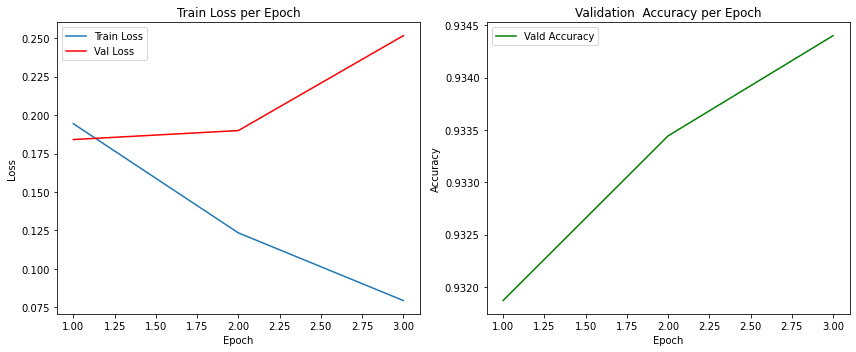

In [75]:
# 학습 후 로그 가져오기
case3_logs = trainer.state.log_history

display_train_graph(logs = case3_logs)

## 4. Fine-tuning을 통하여 모델 성능(accuarcy) 향상시키기
데이터 전처리, TrainingArguments 등을 조정하여 모델의 정확도를 90% 이상으로 끌어올려봅시다

### 4.1 데이타 전처리

Step 3에서 데이타 전처리 수행하여  최대 토큰 길이를 64로 설정하여 시험

### 4.2 TrainingArguments 조정

batch_size = 32
fp16 = True

## 5. Bucketing을 적용하여 학습시키고, STEP 4의 결과와의 비교
 - bucketing과 dynamic padding
 - 모델 성능 향상과 훈련 시간 두 가지 측면에서 각각 어떤 이점이 있는지 비교해봅시다.

* gradient_accumulation_steps

    메모리가 부족할 때 gradient_accumulation_steps를 높이면 효과적

**Dyanmic Padding 적용**
1. tokenizer에 padding='longest'를 적용하는 방법
2. DataCollatorWithPadding을 적용하는 방법

In [12]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=huggingface_tokenizer)

In [13]:
def transform_max(data):
    return huggingface_tokenizer(
        data['document'],
        truncation = True,
        padding = 'max_length',
        max_length=64, 
        return_token_type_ids = False, 
        )

# map을 사용해 토크나이징을 진행하기 때문에 batch를 적용해야 되므로 batched=True로 주어야 한다.
hf_dataset = deduped_dataset.map(transform_max, batched=True)


# 1. train 데이터를 90:10 비율로 나누기
split_ds = hf_dataset['train'].train_test_split(test_size=0.1, seed=42)

# train & test split
hf_train_dataset = split_ds['train']
hf_val_dataset = split_ds['test']
hf_test_dataset = hf_dataset['test']

print(hf_train_dataset)
print(hf_val_dataset)

  0%|          | 0/147 [00:00<?, ?ba/s]

Loading cached processed dataset at /aiffel/.cache/huggingface/datasets/e9t___nsmc)/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3/cache-1ccf56582b9f0239.arrow


Dataset({
    features: ['attention_mask', 'document', 'id', 'input_ids', 'label'],
    num_rows: 131563
})
Dataset({
    features: ['attention_mask', 'document', 'id', 'input_ids', 'label'],
    num_rows: 14619
})


In [14]:
import os
import numpy as np
from transformers import Trainer, TrainingArguments

output_dir = os.getenv('HOME')+'/aiffel/transformers'

training_arguments_5 = TrainingArguments(
    output_dir,                                         # output이 저장될 경로
    evaluation_strategy="epoch",        #evaluation하는 빈도
    logging_strategy="epoch",           # epoch마다 로그 기록
    learning_rate = 2e-5,               #learning_rate
    per_device_train_batch_size = 16,   # 각 device 당 batch size
    per_device_eval_batch_size = 16,    # evaluation 시에 batch size
    num_train_epochs = 3,                     # train 시킬 총 epochs
    weight_decay = 0.01,                        # weight decay
    logging_dir="./case5_logs",
    group_by_length=True,              # 자동 Bucketing 기능. 길이 기준 정렬 + 샘플링을 자동으로 수행
    fp16  = True
)


trainer_5 = Trainer(
    model=huggingface_model,           # 학습시킬 model
    args=training_arguments_5,           # TrainingArguments을 통해 설정한 arguments
    train_dataset=hf_train_dataset,    # training dataset
    eval_dataset=hf_val_dataset,
    compute_metrics=compute_metrics,
    tokenizer=huggingface_tokenizer,
    data_collator=data_collator          # 동적 패딩 적용
)
trainer_5.train()

Using amp fp16 backend
The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running training *****
  Num examples = 131563
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 24669


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.297500,0.267576,0.896026,0.892564
2,0.200400,0.293790,0.898830,0.900531
3,0.136900,0.376648,0.902456,0.902529


/opt/conda/lib/python3.9/site-packages/transformers/trainer.py:1355: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  nn.utils.clip_grad_norm_(
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-500/config.json
Model weights saved in /aiffel/aiffel/transformers/checkpoint-500/pytorch_model.bin
tokenizer config file saved in /aiffel/aiffel/transformers/checkpoint-500/tokenizer_config.json
Special tokens file saved in /aiffel/aiffel/transformers/checkpoint-500/special_tokens_map.json
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-1000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-1000/config.json
Model weights saved 

***** Running Evaluation *****
  Num examples = 14619
  Batch size = 16
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-8500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-8500/config.json
Model weights saved in /aiffel/aiffel/transformers/checkpoint-8500/pytorch_model.bin
tokenizer config file saved in /aiffel/aiffel/transformers/checkpoint-8500/tokenizer_config.json
Special tokens file saved in /aiffel/aiffel/transformers/checkpoint-8500/special_tokens_map.json
/opt/conda/lib/python3.9/site-packages/transformers/trainer.py:1355: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  nn.utils.clip_grad_norm_(
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-9000
Configuration saved in

Configuration saved in /aiffel/aiffel/transformers/checkpoint-16000/config.json
Model weights saved in /aiffel/aiffel/transformers/checkpoint-16000/pytorch_model.bin
tokenizer config file saved in /aiffel/aiffel/transformers/checkpoint-16000/tokenizer_config.json
Special tokens file saved in /aiffel/aiffel/transformers/checkpoint-16000/special_tokens_map.json
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running Evaluation *****
  Num examples = 14619
  Batch size = 16
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-16500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-16500/config.json
Model weights saved in /aiffel/aiffel/transformers/checkpoint-16500/pytorch_model.bin
tokenizer config file saved in /aiffel/aiffel/transformers/checkpoint-16500/tokenizer_config.json
Special tokens file saved in /aiffel/aiffel/transformers/checkpoint-1

Special tokens file saved in /aiffel/aiffel/transformers/checkpoint-23500/special_tokens_map.json
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-24000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-24000/config.json
Model weights saved in /aiffel/aiffel/transformers/checkpoint-24000/pytorch_model.bin
tokenizer config file saved in /aiffel/aiffel/transformers/checkpoint-24000/tokenizer_config.json
Special tokens file saved in /aiffel/aiffel/transformers/checkpoint-24000/special_tokens_map.json
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-24500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-24500/config.json
Model weights saved in /aiffel/aiffel/transformers/checkpoint-24500/pytorch_model.bin
tokenizer config file saved in /aiffel/aiffel/transformers/checkpoint-24500/tokenizer_config.json
Special tokens file saved in /aiffel/aiffel/transformers/checkpoint-24500/special_tokens_map.json
The following columns in the evalu

TrainOutput(global_step=24669, training_loss=0.21158944721075792, metrics={'train_runtime': 5179.416, 'train_samples_per_second': 76.203, 'train_steps_per_second': 4.763, 'total_flos': 1.298087991612288e+16, 'train_loss': 0.21158944721075792, 'epoch': 3.0})

**훈련 결과**

Epoch	Training Loss	Validation Loss	Accuracy	F1
1	0.297500	0.267576	0.896026	0.892564
2	0.200400	0.293790	0.898830	0.900531
3	0.136900	0.376648	0.902456	0.902529


In [15]:
trainer_5.evaluate(hf_test_dataset)

The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running Evaluation *****
  Num examples = 49157
  Batch size = 16


{'eval_loss': 0.3969231843948364,
 'eval_accuracy': 0.8973289663730496,
 'eval_f1': 0.8987664226256143,
 'eval_runtime': 258.5974,
 'eval_samples_per_second': 190.091,
 'eval_steps_per_second': 11.883,
 'epoch': 3.0}

**Evlauate 결과**

{'eval_loss': 0.3969231843948364,
 'eval_accuracy': 0.8973289663730496,
 'eval_f1': 0.8987664226256143,
 'eval_runtime': 258.5974,
 'eval_samples_per_second': 190.091,
 'eval_steps_per_second': 11.883,
 'epoch': 3.0}

## Test 6. Bucketing + Dyanmic Padding +  batch size=32

In [17]:
import os
import numpy as np
from transformers import Trainer, TrainingArguments

output_dir = os.getenv('HOME')+'/aiffel/transformers'

training_arguments_6 = TrainingArguments(
    output_dir,                                         # output이 저장될 경로
    evaluation_strategy="epoch",        #evaluation하는 빈도
    logging_strategy="epoch",           # epoch마다 로그 기록
    learning_rate = 2e-5,               #learning_rate
    per_device_train_batch_size = 32,   # 각 device 당 batch size
    per_device_eval_batch_size = 32,    # evaluation 시에 batch size
    num_train_epochs = 3,                     # train 시킬 총 epochs
    weight_decay = 0.01,                        # weight decay
    logging_dir="./case6_logs",
    group_by_length=True,              # 자동 Bucketing 기능. 길이 기준 정렬 + 샘플링을 자동으로 수행
    fp16  = True
)


trainer_6 = Trainer(
    model=huggingface_model,           # 학습시킬 model
    args=training_arguments_6,           # TrainingArguments을 통해 설정한 arguments
    train_dataset=hf_train_dataset,    # training dataset
    eval_dataset=hf_val_dataset,
    compute_metrics=compute_metrics,
    tokenizer=huggingface_tokenizer,
    data_collator=data_collator          # 동적 패딩 적용
)
trainer_6.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using amp fp16 backend
The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running training *****
  Num examples = 131563
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 12336


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.128200,0.399895,0.895957,0.897153
2,0.086800,0.402270,0.899651,0.900292
3,0.056500,0.497459,0.898488,0.898731


/opt/conda/lib/python3.9/site-packages/transformers/trainer.py:1355: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  nn.utils.clip_grad_norm_(
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-500/config.json
Model weights saved in /aiffel/aiffel/transformers/checkpoint-500/pytorch_model.bin
tokenizer config file saved in /aiffel/aiffel/transformers/checkpoint-500/tokenizer_config.json
Special tokens file saved in /aiffel/aiffel/transformers/checkpoint-500/special_tokens_map.json
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-1000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-1000/config.json
Model weights saved 

Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-8000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-8000/config.json
Model weights saved in /aiffel/aiffel/transformers/checkpoint-8000/pytorch_model.bin
tokenizer config file saved in /aiffel/aiffel/transformers/checkpoint-8000/tokenizer_config.json
Special tokens file saved in /aiffel/aiffel/transformers/checkpoint-8000/special_tokens_map.json
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running Evaluation *****
  Num examples = 14619
  Batch size = 32
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-8500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-8500/config.json
Model weights saved in /aiffel/aiffel/transformers/checkpoint-8500/pytorch_model.bin
tokenizer config file saved in /aiffel/aiffel/transformers/checkpoint-8500/tokenizer_config.json
Specia

TrainOutput(global_step=12336, training_loss=0.09048612324953388, metrics={'train_runtime': 3687.2633, 'train_samples_per_second': 107.041, 'train_steps_per_second': 3.346, 'total_flos': 1.298087991612288e+16, 'train_loss': 0.09048612324953388, 'epoch': 3.0})

**훈련 결과**

Epoch	Training Loss	Validation Loss	Accuracy	F1
1	0.128200	0.399895	0.895957	0.897153
2	0.086800	0.402270	0.899651	0.900292
3	0.056500	0.497459	0.898488	0.898731


In [18]:
trainer_6.evaluate(hf_test_dataset)

The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running Evaluation *****
  Num examples = 49157
  Batch size = 32


{'eval_loss': 0.5275498032569885,
 'eval_accuracy': 0.8942571759871433,
 'eval_f1': 0.8957104450062197,
 'eval_runtime': 234.1746,
 'eval_samples_per_second': 209.916,
 'eval_steps_per_second': 6.563,
 'epoch': 3.0}

**Eval 결과**

{'eval_loss': 0.5275498032569885,
 'eval_accuracy': 0.8942571759871433,
 'eval_f1': 0.8957104450062197,
 'eval_runtime': 234.1746,
 'eval_samples_per_second': 209.916,
 'eval_steps_per_second': 6.563,
 'epoch': 3.0}

## Test 7. Static Padding 40 

In [20]:
def transform_40(data):
    return huggingface_tokenizer(
        data['document'],
        truncation = True,
        padding = 'max_length',
        max_length=40, 
        return_token_type_ids = False, 
        )

# map을 사용해 토크나이징을 진행하기 때문에 batch를 적용해야 되므로 batched=True로 주어야 한다.
hf_dataset = deduped_dataset.map(transform_40, batched=True)


# 1. train 데이터를 90:10 비율로 나누기
split_ds = hf_dataset['train'].train_test_split(test_size=0.1, seed=42)

# train & test split
hf_train_dataset = split_ds['train']
hf_val_dataset = split_ds['test']
hf_test_dataset = hf_dataset['test']

print(hf_train_dataset)
print(hf_val_dataset)


  0%|          | 0/147 [00:00<?, ?ba/s]

  0%|          | 0/50 [00:00<?, ?ba/s]

Dataset({
    features: ['attention_mask', 'document', 'id', 'input_ids', 'label'],
    num_rows: 131563
})
Dataset({
    features: ['attention_mask', 'document', 'id', 'input_ids', 'label'],
    num_rows: 14619
})


In [21]:
import os
import numpy as np
from transformers import Trainer, TrainingArguments

output_dir = os.getenv('HOME')+'/aiffel/transformers'

training_arguments_7 = TrainingArguments(
    output_dir,                                         # output이 저장될 경로
    evaluation_strategy="epoch",           #evaluation하는 빈도
    logging_strategy="epoch",           # epoch마다 로그 기록
    learning_rate = 2e-5,                         #learning_rate
    per_device_train_batch_size = 32,   # 각 device 당 batch size
    per_device_eval_batch_size = 32,    # evaluation 시에 batch size
    num_train_epochs = 3,                     # train 시킬 총 epochs
    weight_decay = 0.01,                        # weight decay
    logging_dir="./case7_logs",
    fp16  = True
)


trainer_7 = Trainer(
    model=huggingface_model,           # 학습시킬 model
    args=training_arguments_7,           # TrainingArguments을 통해 설정한 arguments
    train_dataset=hf_train_dataset,    # training dataset
    eval_dataset=hf_val_dataset,
    compute_metrics=compute_metrics,
)
trainer_7.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using amp fp16 backend
The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running training *****
  Num examples = 131563
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 12336


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.091800,0.469986,0.896094,0.895938
2,0.059700,0.525887,0.894794,0.893946
3,0.036200,0.644093,0.895136,0.894429


/opt/conda/lib/python3.9/site-packages/transformers/trainer.py:1355: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  nn.utils.clip_grad_norm_(
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-500/config.json
Model weights saved in /aiffel/aiffel/transformers/checkpoint-500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-1000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-1000/config.json
Model weights saved in /aiffel/aiffel/transformers/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-1500
Configuration saved in /aiffel/aiffel/transformers/check

Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-12000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-12000/config.json
Model weights saved in /aiffel/aiffel/transformers/checkpoint-12000/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running Evaluation *****
  Num examples = 14619
  Batch size = 32


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=12336, training_loss=0.062596977916673, metrics={'train_runtime': 2996.0945, 'train_samples_per_second': 131.734, 'train_steps_per_second': 4.117, 'total_flos': 8113049947576800.0, 'train_loss': 0.062596977916673, 'epoch': 3.0})

**훈련 결과**

Epoch	Training Loss	Validation Loss	Accuracy	F1
1	0.091800	0.469986	0.896094	0.895938
2	0.059700	0.525887	0.894794	0.893946
3	0.036200	0.644093	0.895136	0.894429


In [22]:
trainer_7.evaluate(hf_test_dataset)

The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running Evaluation *****
  Num examples = 49157
  Batch size = 32


{'eval_loss': 0.6702513098716736,
 'eval_accuracy': 0.8927314522855341,
 'eval_f1': 0.8937302243092364,
 'eval_runtime': 159.9714,
 'eval_samples_per_second': 307.286,
 'eval_steps_per_second': 9.608,
 'epoch': 3.0}

**Eval 결과**

{'eval_loss': 0.6702513098716736,
 'eval_accuracy': 0.8927314522855341,
 'eval_f1': 0.8937302243092364,
 'eval_runtime': 159.9714,
 'eval_samples_per_second': 307.286,
 'eval_steps_per_second': 9.608,
 'epoch': 3.0}

In [19]:
import torch

total_memory = torch.cuda.get_device_properties(0).total_memory
print(f"Total GPU Memory: {total_memory / (1024 ** 3):.2f} GB")

print(torch.cuda.memory_summary())


Total GPU Memory: 14.56 GB
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |    2592 MB |    3968 MB |  196121 GB |  196118 GB |
|       from large pool |    2589 MB |    3965 MB |  195334 GB |  195331 GB |
|       from small pool |       2 MB |      30 MB |     786 GB |     786 GB |
|---------------------------------------------------------------------------|
| Active memory         |    2592 MB |    3968 MB |  196121 GB |  196118 GB |
|       from large pool |    2589 MB 

In [27]:
import torch
#torch.cuda.empty_cache()

# < 회고 >

## Test 결과 Summary

| Case  | Description | Batch Size | Epoch | Max Padding | Training Loss | Val Loss | Val Accuracy | Val F1 | Eval Loss | Eval Accuracy | Eval F1 |
|-------|-------------|------------|-------------|-------------|----------|----|---------------|---------------|----|---------------|---------------|
| TC_1  | 기본 시험    | 32         | 3     | 64          | 0.079400        | 0.251641  | 0.934400             | 0.934193   | 0.446057  | 0.896352             | 0.897754  |
| TC_2  | bucketing + Dyanmic Padding    | 16         | 3     | 64          | 0.136900        | 0.376648  | 0.902456             | 0.902529   | 0.396923  |     0.897328         | 0.898766  |
| TC_3  | bucketing + Dyanmic Padding    | 32         | 3     | 64          |  0.056500      |0.497459   |    0.898488          |  0.898731  |  0.527549 |      0.894257        |  0.895710 |
| TC_4  | 기본 시험   | 32         | 3     | 40          |     0.036200   |  0.644093 |    0.895136          | 0.894429   | 0.670251  |     0.892731         |  0.893730 |


✅ Validation 기준으로는  TC_1 64길이의 static padding 적용한 시험 성능이 가장 좋다 

✅ Evaluation 기준으로는  TC_2 64길이의 dynamic padding  + batch 16을 적용한 시험 성능이 가장 좋다

✅ 데이타 분포에 맞게 padding의 max_length를 적용하는 것이,  daynamic padding을 사용하는 것보다 성능이 더 좋게 나왔고, 시간도 줄었다.
   -  토큰 길이가 64 이하인  비율: 0.975 (총 142522개)
   -  토큰 길이가 40 이하인  비율: 0.910 (총 133079개)


- Batch 크기 
    - 배치 크기가 커지면 일반화 성능 향상 가능성 있음  (시험 결과에서는 training loss는 줄었으나, 다른 지표는 좋지 않음)

- Bucketing
    * TrainingArguments의 group_by_length는 입력 시퀀스 길이에 따라 배치 구성 방식을 제어하는 옵션
    * 유사한 길이의 샘플끼리 한 배치(batch)에 묶어서 학습

    - 패딩 토큰 낭비 최소화
    - 메모리 효율 증가
    - 동일한 길이끼리 묶이면 병렬 처리 효율 증가 

- Dynamic Padding 
    - 패딩이 적어서 계산량이 줄어드므로, 훈련시간이 빨라짐 
    - 성능 측면에서는 거의 동일 (약간 높아질 수 있음)

#### Dynamic Padding  Test  참고 사항 

- Dynamic Padding 시험을 위해서, padding을 max_length(512)로 시험한 경우, CUDA out of memory 발생하여, 커널 restart시에도 해결되지 않았다. 
- padding을 64로 줄이고, empty_cache()하고 batch size 32 -> 16으로 변경하고, 커널 restart 후 Dynamic Padding 시험이 정상 수행되었다.
- 데이타 분포를 확인하여, 수동을 padding size를 줄이는 것과 dynamic padding의 시험 결과를 비교하려고 하였는데, 512 length는 메모리를 너무 많이 소요시켜서, 여기서는 시험을 할 수 없고, 
- 64개로 설정한 것에서 dynamic padding 적용후 시간 및 성능 비교를 하였다. 
    + 64개 static padding + 32 batch : 'train_runtime': 3315.6737 'eval_runtime': 240.6759,
    + 64개 dynamic padding + 16 batch : train_runtime': 5179.416  'eval_runtime': 258.5974,  <-- batch size 가 줄어서 시간이 더 걸림
    + 64개 dynamic padding + 32 batch : 'train_runtime': 3687.2633 'eval_runtime': 234.1746
   


#### CUDA out of memory 관련 

GPU reserved memory   |    2648 MB   # PyTorch가 예약해 놓은 전체 메모리
Allocated memory      |    1730 MB   # 현재 PyTorch에서 실제로 사용 중인 메모리 크기
Non-releasable memory |  107857 KB   # PyTorch가 캐시하고 있지만 empty_cache()를 해도 해제되지 않는 메모리

--> PyTorch가 2.648G 예약한 상태에서 1.7G allocted이며, 여유공간은 약 0.92GB인데, 할당하려는 사이즈가 이것보다 크면 OOM 발생하게 된다. 